In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
# Hyperparameters

n_epochs = 15
batch_size_train =64
batch_size_test = 64
learning_rate = 0.01
momentum = 0.1
log_interval = 256
random_seed = 1
number_classes=10
torch.cuda.empty_cache()  # For CUDA, adjust for MPS if similar functionality exists
# Setting random seed for reproducibility
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Set device to MPS if available, otherwise fallback to CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: mps


In [2]:
# Download and transform the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./mnist_data', download=True, train=True, transform=transform)
test_dataset = datasets.MNIST('./mnist_data', download=True, train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  
# Create DataLoader for subsets
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size_test,
    shuffle=False
)
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Conv layer with padding
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Another conv layer with padding
        self.conv2_drop = nn.Dropout2d(p=.2)  # Dropout layer with dropout rate

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)  # Pooling layer with a kernel size of 2

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted for output size from conv layers
        self.fc2 = nn.Linear(128, 10)
      #  self.fc3 = nn.Linear(64, 10)  # Assuming MNIST (10 classes)
      #  self.bn3=nn.BatchNorm1d(1)

    def forward(self, x):
        # Apply the first convolutional layer, followed by batch normalization, ReLU activation, and pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Apply the second convolutional layer, then dropout, batch normalization, ReLU, and pooling
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = self.bn2(x)
        x = F.gelu(x)
        x = self.pool(x)
        
        # Flatten the output from the conv layers to feed into the fully connected layer
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        
        # Apply the first fully connected layer with ReLU activation and dropout
        x = self.fc1(x)
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)
    #    
        # Second fully connected layer with ReLU and dropout
        x = self.fc2(x)
   #     x = F.relu(x)
  #      x = F.dropout(x, training=self.training)
        
   #     # Output layer that outputs class scores for softmax
     #   x = self.fc3(x)
      #  x = self.bn3(x)
        
        # Apply softmax to the final output for class probability distribution
        x = F.softmax(x, dim=1)  # Softmax over classes
        
        return x


In [6]:
def Bayes_loss(output, target):
  
    batch_size = output.size(0)
    num_classes = output.size(1)
    
    # Create a mask for the losses
    mask = torch.arange(num_classes, device=target.device).expand(batch_size, num_classes)
    target = target.unsqueeze(1).expand_as(mask)
    
    # Calculate the loss
    loss = (mask >= target).float() * output
    loss += (mask == (target - 1)).float() * (1 - output)
    
    return loss.sum() / batch_size

In [7]:
def train(epoch, loader, model, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        be = Bayes_loss(output[:,1:10], target)
        be = be / number_classes
        be.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loader.dataset)} ({100. * batch_idx / len(loader):.0f}%)]\tLoss: {be.item():.6f}')

In [8]:
def test(loader, model, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    embeddings = []
    labels = []
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            embeddings.append(outputs)  # Collect embeddings
            labels.append(target)
            _, predicted = outputs.max(1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    
    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Convert embeddings and labels to tensors
    embeddings = torch.cat(embeddings).cpu()
    labels = torch.cat(labels).cpu()
    
    return embeddings, labels

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.130292
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.062669
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.054095
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.048571
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.060136
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.050107
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.044837
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.034805
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.013628
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.030930
Test Accuracy: 78.21%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.026198
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.024294
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.015698
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.016924
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.009364
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.020462
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.011848
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.013314
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.019713
Train Epoch: 2 [57600/60000 (96%)]	Loss:

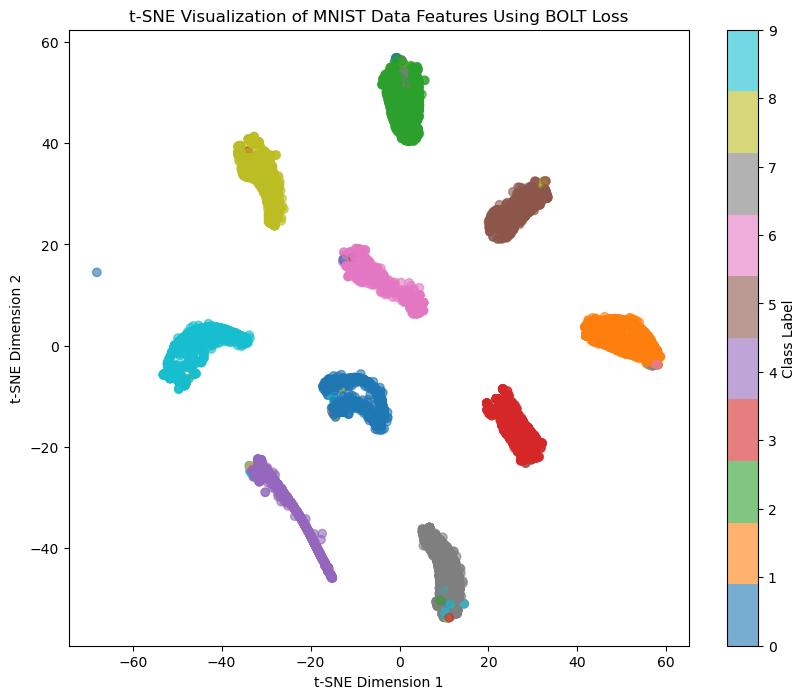

In [9]:
network1 = Net1().to(device)
params = list(network1.parameters())
#optimizer =torch.optim.Adam(network1.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=1e-4, amsgrad=True)
#optimizer = optim.SGD(params, lr=learning_rate, momentum=momentum)
#from torch.optim.lr_scheduler import ExponentialLR

# Assuming 'model' is already defined and moved to 'device'
optimizer = optim.Adam(network1.parameters(), lr=0.001)
#scheduler = ExponentialLR(optimizer, gamma=0.99)  # Reduces lr by 5% each epoch

for epoch in range(1, n_epochs + 1):
    train(epoch, train_loader, network1, optimizer)
  #  scheduler.step()  # Update the learning rate
    test(test_loader, network1, device)
# Save the trained model
torch.save(network1.state_dict(), "mnist_model.pth")
print("Model saved as mnist_model.pth")

def test(loader, network1, device):
    network1.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device)
            outputs = network1(data)
          #  print(outputs.shape)
            _, predicted = torch.max(outputs.data, 1)
           # print("predict")
            #print(predicted)
            #print("targets")
            #print(targets)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    print(f'Accuracy of the network on the MNIST test images: {100 * accuracy:.2f}%')

# Function to visualize t-SNE
def visualize_tsne(loader, network1, device):
    network1.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            outputs = network1(data)
            all_features.append(outputs.cpu().numpy())
            all_labels.append(targets.numpy())

    # Flatten lists
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(all_features)

    # Visualize with matplotlib
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=all_labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Class Label')
    plt.title('t-SNE Visualization of MNIST Data Features Using BOLT Loss')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    # Save the plot
    plt.savefig("tsne_plot.png", format="png", dpi=300)  # Save as PNG with high resolution
    plt.savefig("tsne_plot.pdf", format="pdf")  # Save as PDF

    plt.show()

# Call the t-SNE visualization function after testing
test(test_loader, network1, device)
visualize_tsne(test_loader, network1, device)